# Digit Recognizer
**MNIS** ("*Modified National Institute of Standards and Technology*") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

### Image Description
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

### Dataset Info
The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class DigitDataset(Dataset):

    def __init__(self, csv_file, is_test, transform=None):
        super().__init__()

        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        item = self.df.iloc[index]

        if self.is_test:
            image = item.values.reshape(28, 28).astype(np.float16)
            label = None
        
        else:
            image = item[1:].values.reshape(28, 28).astype(np.float16)
            label = item.iloc[0]

        if self.transform is not None:
            image = self.transform(image)
        
        if self.is_test:
            return image
        
        else:
            return image, label

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [5]:
train_dataset = DigitDataset('./../datasets/digit-recognizer-train.csv', False, transform)
test_dataset = DigitDataset('./../datasets/digit-recognizer-test.csv', True, transform)

In [6]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, True)
test_loader = DataLoader(test_dataset, batch_size, False)

Input size: torch.Size([1, 28, 28])


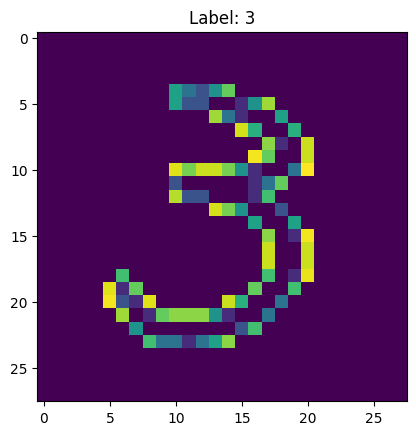

In [7]:
import random
data = random.choice(train_dataset)
label = data[1]
image = data[0]

print('Input size:', image.size())
numpy_img = image.numpy()

plt.imshow(numpy_img.squeeze())
plt.title(f'Label: {label}')
plt.show()

In [8]:
class DigitNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 5), 
            nn.ReLU(),
            nn.MaxPool2d(3, 3),

            nn.Conv2d(32, 64, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*3*3, 256),
            nn.ReLU(),

            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 10)         
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        return self.linear_layers(x)

In [9]:
model = DigitNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())

In [10]:
num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0
    n_elements = 0
    n_correct = 0 

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()

        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        n_correct += (y_batch == pred).sum().item()
        n_elements += len(y_batch)


    print(f"Epoch {epoch+1}, total loss: {total_loss}, accuracy: {n_correct/n_elements}")

Epoch 1, total loss: 456.7796914279461, accuracy: 0.7631428571428571
Epoch 2, total loss: 174.00590233504772, accuracy: 0.9148333333333334
Epoch 3, total loss: 132.5881542339921, accuracy: 0.9356666666666666
Epoch 4, total loss: 112.42075645923615, accuracy: 0.945
Epoch 5, total loss: 103.98302797786891, accuracy: 0.9488571428571428
Epoch 6, total loss: 91.7057779924944, accuracy: 0.9554523809523809
Epoch 7, total loss: 84.96378381364048, accuracy: 0.9596190476190476
Epoch 8, total loss: 82.61974498722702, accuracy: 0.9595714285714285
Epoch 9, total loss: 76.61541205644608, accuracy: 0.9628809523809524
Epoch 10, total loss: 73.94339844025671, accuracy: 0.9637857142857142
Epoch 11, total loss: 69.24773691501468, accuracy: 0.9661904761904762
Epoch 12, total loss: 65.75267267879099, accuracy: 0.9673333333333334
Epoch 13, total loss: 65.74069523531944, accuracy: 0.9678095238095238
Epoch 14, total loss: 62.77541145356372, accuracy: 0.9691428571428572
Epoch 15, total loss: 59.31744722905569,

In [ ]:
predictions = []
with torch.no_grad():
    for x_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)

        _, pred = torch.max(outputs, 1)
        predictions.extend(pred.cpu().numpy())
        
predictions = np.array(predictions) 

In [12]:
df_submission = pd.DataFrame({'ImageId': np.array([i+1 for i in range(len(predictions))]), 'Label': predictions})
df_submission.to_csv('./../submissions/digit-recognizer-submission.csv', index=False)

### Score
This approach allowed us to score 0.96 on public :D